# What's in this notebook
- [Dataset](#dataset)
- [Modeling](#model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from sklearn import preprocessing, metrics, model_selection

%matplotlib inline

/Users/xinyue/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# <a name='dataset'></a>Dataset
For the univariate time-series analysis example, I'm going to use the dataset [The total generation of electricity by the U.S. electric industry (monthly data for the period Jan. 1985 – Oct. 1996)](https://datamarket.com/data/set/22wj/the-total-generation-of-electricity-by-the-us-electric-industry-monthly-data-for-the-period-jan-1985-oct-1996-for-recent-data-click-here#!ds=22wj&display=line) downloaded from [Time Series Data Library](https://datamarket.com/data/list/?q=).

Description of this dataset can be found [here](../../z_datasets/Datasets.ipynb#elec_gen_univar)

EDA of this dataset can be found in another notebook: [time_series_ARIMA_univariate.ipynb](time_series_ARIMA_univariate.ipynb)

In [2]:
# import univariate time-series data
data = pd.read_csv('../../z_datasets/time_series/the-total-generation-of-electric.csv', 
                   names=['month', 'generation'], index_col='month', header=0)

# drop the last row
data.drop(data.tail(1).index, inplace=True)

# convert index to datetime index and convert generation to float
data.index = pd.to_datetime(data.index)
data.generation  = data.generation.astype(np.float)

data.head()

,generation
month,
1985-01-01,227.86
1985-02-01,198.24
1985-03-01,194.97
1985-04-01,184.88
1985-05-01,196.79


# <a name='model'></a>Modeling

I'll use a moving forward window so to use the previous data to make a prediction at the next time step. For example, if use a moving forward window of size 12, then it means we will use the first 12 data points X0 to X11 as input X to predict y1 to y12, use X1 to X12 to predict y2 to y13, and so on. 

The input into a LSTM model need to be reshaped into a 3D array with the shape of (num_samples, num_time_steps, num_features). 

Also, as LSTM is sensitive to scale, the input data needs to be normalized, and the output data needs to be converted back to original scale.

As to prediction, there are different approaches, such as:
    1. Step by step
    2. Use prediction from the last step to predict current time step

## <a name='transform'></a>Data Transformation
In order to prepare the data for LSTM, we need to transform data into formats that are suitable for the LSTM model. The transformations include:
1. Transform the data to a supervided learning problem.
2. Normalize data to [-1, 1] (LSTM is sensitive to scale. The range of tanh output is (-1, 1))

In [9]:
# normalize data using MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(data)
series = pd.DataFrame(scaled)

# use pandas shift function to transform the data to a supervised learning problem
window_size = 12

s = series.copy()
colnames = ['t0']
for i in range(1, window_size+1):
    series = pd.concat([series, s.shift(i)], axis = 1)
    colnames.append('t-'+str(i))

series.columns = colnames
series = series.dropna(axis=0)
series.head()

,t0,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12
12,-0.456063,-0.426354,-0.873988,-0.834599,-0.705917,-0.312860,-0.301677,-0.658182,-0.801218,-1.000000,-0.831595,-0.777017,-0.282650
13,-0.875490,-0.456063,-0.426354,-0.873988,-0.834599,-0.705917,-0.312860,-0.301677,-0.658182,-0.801218,-1.000000,-0.831595,-0.777017
14,-0.800551,-0.875490,-0.456063,-0.426354,-0.873988,-0.834599,-0.705917,-0.312860,-0.301677,-0.658182,-0.801218,-1.000000,-0.831595
15,-0.980139,-0.800551,-0.875490,-0.456063,-0.426354,-0.873988,-0.834599,-0.705917,-0.312860,-0.301677,-0.658182,-0.801218,-1.000000
16,-0.792539,-0.980139,-0.800551,-0.875490,-0.456063,-0.426354,-0.873988,-0.834599,-0.705917,-0.312860,-0.301677,-0.658182,-0.801218


Now t0 becomes the target y and t-1 to t-12 are features

In [12]:
series.shape

(130, 13)

In [57]:
# train-test split
cut = int(0.7*len(series))
train, test = series[0: cut], series[cut:]

In [78]:
train_X = train.iloc[:, 1:].values
train_y = train.iloc[:, 0].values
test_X = test.iloc[:, 1:].values
test_y = test.iloc[:, 0].values

print('{}.shape = {}'.format('train_X', train_X.shape))
print('{}.shape = {}'.format('train_y', train_y.shape))
print('{}.shape = {}'.format('test_X', test_X.shape))
print('{}.shape = {}'.format('test_y', test_y.shape))

train_X.shape = (91, 12)
train_y.shape = (91,)
test_X.shape = (39, 12)
test_y.shape = (39,)


In [80]:
# reshape data to 3D array for LSTM input: (num_samples, num_time_steps, num_features)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
print('{}.shape = {}'.format('train_X', train_X.shape))
print('{}.shape = {}'.format('test_X', test_X.shape))

train_X.shape = (91, 12, 1)
test_X.shape = (39, 12, 1)


In [84]:
# model architecture of double stacked LSTM years  
# the output from the first LSTM at each time step is fed to the second LSTM
model = Sequential()
model.add(LSTM(units = 12, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.4, return_sequences=True))
model.add(LSTM(12, dropout=0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 12, 12)            672       
_________________________________________________________________
lstm_21 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 13        
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


In [85]:
# fit model
history = model.fit(train_X, train_y, batch_size=64, epochs=500, validation_data=(test_X, test_y), shuffle=False)

Train on 91 samples, validate on 39 samples
Epoch 1/500
91/91 [==============================] - 3s 32ms/step - loss: 0.2332 - val_loss: 0.1486
Epoch 2/500
91/91 [==============================] - 0s 625us/step - loss: 0.2229 - val_loss: 0.1499
Epoch 3/500
91/91 [==============================] - 0s 570us/step - loss: 0.2130 - val_loss: 0.1513
Epoch 4/500
91/91 [==============================] - 0s 583us/step - loss: 0.2036 - val_loss: 0.1529
Epoch 5/500
91/91 [==============================] - 0s 580us/step - loss: 0.1961 - val_loss: 0.1547
Epoch 6/500
91/91 [==============================] - 0s 589us/step - loss: 0.1842 - val_loss: 0.1568
Epoch 7/500
91/91 [==============================] - 0s 591us/step - loss: 0.1783 - val_loss: 0.1590
Epoch 8/500
91/91 [==============================] - 0s 577us/step - loss: 0.1746 - val_loss: 0.1615
Epoch 9/500
91/91 [==============================] - 0s 574us/step - loss: 0.1617 - val_loss: 0.1643
Epoch 10/500
91/91 [============================

Epoch 81/500
91/91 [==============================] - 0s 591us/step - loss: 0.1127 - val_loss: 0.2010
Epoch 82/500
91/91 [==============================] - 0s 613us/step - loss: 0.1050 - val_loss: 0.2011
Epoch 83/500
91/91 [==============================] - 0s 614us/step - loss: 0.1182 - val_loss: 0.2013
Epoch 84/500
91/91 [==============================] - 0s 614us/step - loss: 0.1015 - val_loss: 0.2015
Epoch 85/500
91/91 [==============================] - 0s 592us/step - loss: 0.1205 - val_loss: 0.2016
Epoch 86/500
91/91 [==============================] - 0s 585us/step - loss: 0.1155 - val_loss: 0.2015
Epoch 87/500
91/91 [==============================] - 0s 582us/step - loss: 0.1165 - val_loss: 0.2014
Epoch 88/500
91/91 [==============================] - 0s 601us/step - loss: 0.1157 - val_loss: 0.2012
Epoch 89/500
91/91 [==============================] - 0s 564us/step - loss: 0.1201 - val_loss: 0.2012
Epoch 90/500
91/91 [==============================] - 0s 614us/step - loss: 0.1174

91/91 [==============================] - 0s 624us/step - loss: 0.0506 - val_loss: 0.1483
Epoch 240/500
91/91 [==============================] - 0s 634us/step - loss: 0.0525 - val_loss: 0.1498
Epoch 241/500
91/91 [==============================] - 0s 578us/step - loss: 0.0636 - val_loss: 0.1505
Epoch 242/500
91/91 [==============================] - 0s 577us/step - loss: 0.0675 - val_loss: 0.1503
Epoch 243/500
91/91 [==============================] - 0s 585us/step - loss: 0.0639 - val_loss: 0.1506
Epoch 244/500
91/91 [==============================] - 0s 594us/step - loss: 0.0557 - val_loss: 0.1526
Epoch 245/500
91/91 [==============================] - 0s 578us/step - loss: 0.0652 - val_loss: 0.1596
Epoch 246/500
91/91 [==============================] - 0s 569us/step - loss: 0.0833 - val_loss: 0.1691
Epoch 247/500
91/91 [==============================] - 0s 617us/step - loss: 0.0498 - val_loss: 0.1786
Epoch 248/500
91/91 [==============================] - 0s 575us/step - loss: 0.0583 - v

91/91 [==============================] - 0s 627us/step - loss: 0.0383 - val_loss: 0.1017
Epoch 398/500
91/91 [==============================] - 0s 606us/step - loss: 0.0548 - val_loss: 0.1049
Epoch 399/500
91/91 [==============================] - 0s 606us/step - loss: 0.0430 - val_loss: 0.1091
Epoch 400/500
91/91 [==============================] - 0s 571us/step - loss: 0.0403 - val_loss: 0.1117
Epoch 401/500
91/91 [==============================] - 0s 547us/step - loss: 0.0421 - val_loss: 0.1136
Epoch 402/500
91/91 [==============================] - 0s 538us/step - loss: 0.0315 - val_loss: 0.1130
Epoch 403/500
91/91 [==============================] - 0s 538us/step - loss: 0.0429 - val_loss: 0.1159
Epoch 404/500
91/91 [==============================] - ETA: 0s - loss: 0.051 - 0s 535us/step - loss: 0.0483 - val_loss: 0.1206
Epoch 405/500
91/91 [==============================] - 0s 508us/step - loss: 0.0341 - val_loss: 0.1235
Epoch 406/500
91/91 [==============================] - 0s 512us

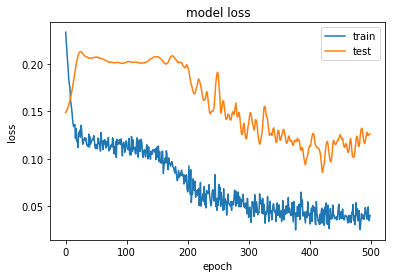

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [75]:
# predict all test data at once
predictions = model.predict(test_X)

In [76]:
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(test_y)

/Users/xinyue/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


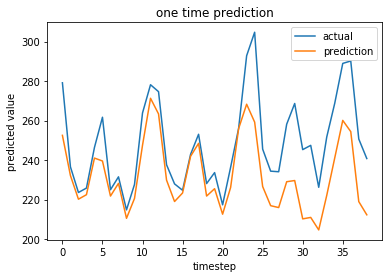

In [87]:
plt.plot(actuals)
plt.plot(predictions)
plt.title('one time prediction')
plt.xlabel('timestep')
plt.ylabel('predicted value')
plt.legend(['actual', 'prediction'], loc='upper right')
plt.show()

In [88]:
def moving_window(n_preds):
    preds = []
    # first test window
    moving_test_window = np.array([test_X[0, :].tolist()])
    
    for i in range(n_preds):
        preds_one_step = model.predict(moving_test_window)
        preds.append(preds_one_step[0, 0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1)
        # remove the first element of the moving_test_window
        # and add preds_one_step to the end of the moving_test_window
        moving_test_window = np.concatenate((moving_test_window[:, 1:, :], preds_one_step), axis=1)
    
    preds = scaler.inverse_transform(preds)
    return preds

In [90]:
preds_moving = moving_window(12)

/Users/xinyue/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


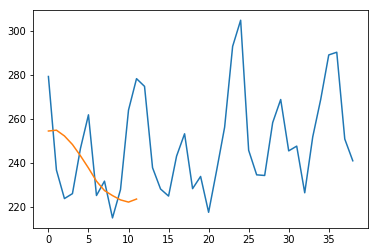

In [91]:
plt.plot(actuals)
plt.plot(preds_moving)
plt.show()

In [ ]:
def ts_to_supervised(series, lag=1):
    df = pd.DataFrame({'target': series})
    for i in range(1, lag+1):
        colname = 'lag_' + str(i)
        df[colname] = series.shift(i)
    return df

In [ ]:
# rescale data to [-1, 1]
def scale(df):
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    df = scaler.fit_transform(df)
    return scaler, df

# inverse scaling for forcasted value
def inverse_scale(scaler, X, value):
    ar = np.array([x for x in X] + [value])
    ar = ar.reshape(1, len(ar))
    inverted = scaler.inverse_transform(ar)
    return inverted[0, -1]

In [ ]:
# fit an LSTM to training data
def fit_lstm(train, batch_size, epoch, neurons, timestep=1):
    X, y = train[:, 1:], train[:, 0]
    # reshape data to 3D array for LSTM input: (num_samples, num_time_steps, num_features)
    X = X.reshape(X.shape[0], timestep, X.shape[1])
    
    model = models.Sequential()
    model.add(layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    for i in range(epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
# one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

In [ ]:
# first order difference to make data stationary
differenced = difference(data.generation)
differenced.head()

In [ ]:
# transform to a supervided problem
supervised = ts_to_supervised(differenced)
supervised.head()

In [ ]:
supervised = supervised.dropna()
supervised.head()

In [ ]:
# transform and scale data
scaler, scaled = scale(supervised)
scaled[0:5]

In [ ]:
# train-test split
cut = int(0.67*len(scaled))
train, test = scaled[0: cut], scaled[cut:]

In [ ]:
# fit model
lstm_model = fit_lstm(train, 1, 2000, 10)

In [ ]:
# forecast the entire training set to build up state for forecasting
train_reshaped = train[: , 0].reshape(len(train), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

In [ ]:
# walk-forward validation on the test data
predictions = []
for i in range(len(test)):
    # one-step forecast
    X, y = test[i, 1:], test[i, 0]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yaht = inverse_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(data.generation.values[2:], yaht, len(test)+1-i)
    # store forecast
    predictions.append(yhat)

In [ ]:
mse = metrics.mean_squared_error(data.generation.values[-len(test):], predictions)
print (mse)

In [ ]:
plt.plot(data.generation.values[-len(test):])
plt.plot(predictions)
plt.show()

## <a name='data-split'></a>Train-Test Split
It is tricky to perform regular train-test split in k-fold cross-validation with time-series data due to dependencies on historical data points. Below is a good illustration of how time series cross-validation differs from traditional evaluation and standard cross validation methods.
![](./images/TS_CV.jpg)

Source: [Automatic time series forecasting, #71](https://www.slideshare.net/hyndman/automatic-time-series-forecasting)

Luckily, we can use [`scikit-learn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for time-series cross validation.